In [1]:
import os
import numpy as np
import tempfile
from tqdm import tqdm  
from PIL import Image
from stl import mesh
import tripy
import plotly.graph_objects as go
# from vedo import load, write, Points
import keras.backend as K
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten, Activation
from keras.layers import Embedding, Lambda, Concatenate, Add
from keras.layers import Conv3DTranspose, Conv3D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import GlobalAvgPool3D, Multiply, GlobalAveragePooling3D
import stltovoxel
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Preprocesamiento

In [ ]:
def off_to_stl(input_path, output_path):
    """
    source: https://github.com/lmcanavals/machine_learning/blob/c85123540688c09f63725c51845b8d478f37fbf4/1302_off_to_png_and_stl.ipynb
    """
    with open(input_path, 'r') as off_file:
        lines = off_file.readlines()

    if len(lines) < 2:
        print(f"Error: Insufficient lines in {input_path}")
        return None

    counts = lines[1].split()

    if len(counts) != 3 or not all(c.isdigit() for c in counts):
        print(f"Error: Invalid counts format in {input_path}")
        return None

    vertex_count, face_count, _ = map(int, counts)

    if len(lines) < 2 + vertex_count:
        print(f"Error: Insufficient vertex lines in {input_path}")
        return None

    vertices = []
    for i, line in enumerate(lines[2:2 + vertex_count], start=2):
        values = line.split()[0:3]
        if len(values) != 3 or not all(v.replace('.', '', 1).replace('-', '', 1).isdigit() for v in values):
            print(f"Error: Invalid vertex format in {input_path}. Line {i}: {line}")
            return None
        vertices.append(list(map(float, values)))

    if len(lines) < 2 + vertex_count + face_count:
        print(f"Error: Insufficient face lines in {input_path}")
        return None

    faces = []
    for line in lines[2 + vertex_count:]:
        values = line.split()[1:]
        if len(values) < 3 or not all(v.lstrip('-').isdigit() for v in values):
            print(f"Error: Invalid face format in {input_path}. Problematic line: {line}")
            return None
        faces.append(list(map(int, values)))

    vertices = np.array(vertices)
    stl_mesh = mesh.Mesh(np.zeros(len(faces), dtype=mesh.Mesh.dtype))

    for i, face in enumerate(faces):
        for j in range(3):
            stl_mesh.vectors[i][j] = vertices[face[j]]

    stl_mesh.save(output_path)
    return stl_mesh
    
def convertir_carpeta(input_folder, output_folder):
    """
    source: https://github.com/lmcanavals/machine_learning/blob/c85123540688c09f63725c51845b8d478f37fbf4/1302_off_to_png_and_stl.ipynb
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)


    for filename in os.listdir(input_folder):
        if filename.endswith(".off"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + ".stl")
            off_to_stl(input_path, output_path)
def xyz_to_tensor(input, dim):
    with open(input, 'r') as xyz_file:
        coords = []
        min_x = float('inf')
        min_y = float('inf')
        min_z = float('inf')
        max_x = float('-inf')
        max_y = float('-inf')
        max_z = float('-inf')
        lines = xyz_file.readlines()
        for line in lines:
            coord_tuple = line.split()
            x, y, z = float(coord_tuple[0]), float(coord_tuple[1]), float(coord_tuple[2])

            min_x = min(min_x, x)
            min_y = min(min_y, y)
            min_z = min(min_z, z)
            max_x = max(max_x, x)
            max_y = max(max_y, y)
            max_z = max(max_z, z)

            coords.append((x, y, z))

    range_x = max_x - min_x
    range_y = max_y - min_y
    range_z = max_z - min_z

    scale_x = dim / range_x
    scale_y = dim / range_y
    scale_z = dim / range_z

    # 3D tensor filled with zeros
    tensor = [[[0 for _ in range(dim)] for _ in range(dim)] for _ in range(dim)]

    # Point mapping
    for x, y, z in coords:
        # Scaling
        scaled_x = int((x - min_x) * scale_x)
        scaled_y = int((y - min_y) * scale_y)
        scaled_z = int((z - min_z) * scale_z)
        if 0 <= scaled_x < dim and 0 <= scaled_y < dim and 0 <= scaled_z < dim:
            # Setting to 1
            # TODO: change range to 31 instead of 32
            tensor[scaled_x][scaled_y][scaled_z] = 1

    return tensor

def readOff(filename):
    f = open(filename)
    f.readline()
    nvertices, nfaces, nedges = map(int, f.readline().split())
    vertices = []
    for _ in range(nvertices):
        vertices.append(list(map(float, f.readline().strip().split())))
    vertices = np.array(vertices)

    triangles = []
    for _ in range(nfaces):
        face = list(map(int, f.readline().strip().split()))
        ntriangles, verts = face[0] - 3 + 1, face[1:]
        for n in range(ntriangles):
            triangles.append([verts[0], verts[1 + n], verts[2 + n]])
    triangles = np.array(triangles)

    return vertices, triangles

def save_png(off_filename, png_filename):
    vertices, faces = readOff(off_filename)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(vertices[faces])
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)

    ax.set_xlim([min(vertices[:, 0]), max(vertices[:, 0])])
    ax.set_ylim([min(vertices[:, 1]), max(vertices[:, 1])])
    ax.set_zlim([min(vertices[:, 2]), max(vertices[:, 2])])

    plt.axis('off')  # Turn off the axis
    plt.savefig(png_filename, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()


def process_directory(root_dir):
    X_train, y_train, X_test, y_test = [], [], [], []
    skip_count = 0
    for class_dir in os.listdir(root_dir):
        for dataset_type in ['train', 'test']:
            dataset_dir = os.path.join(root_dir, class_dir, dataset_type)
            for filename in os.listdir(dataset_dir):
                if filename.endswith(".off"):
                    input_path = os.path.join(dataset_dir, filename)
                    temp_stl_path = "./temporary.stl"
                    temp_xyz_path = "./temporary.xyz"
                    temp_png_path = "./temporary.png"

                    off_to_stl(input_path, temp_stl_path)
                    try:
                        stltovoxel.convert_file(temp_stl_path, temp_xyz_path, resolution)
                        voxel_tensor = xyz_to_tensor(temp_xyz_path, tensor_size)                    
                        save_png(input_path, temp_png_path)
                    except:
                        skip_count += 1
                        continue

                    image = Image.open(temp_png_path).convert('L').resize((128, 128))
                    image_tensor = np.array(image).reshape(128, 128, 1)

                    if dataset_type == 'train':
                        X_train.append(voxel_tensor)
                        y_train.append(image_tensor)
                    else:
                        X_test.append(voxel_tensor)
                        y_test.append(image_tensor)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

resolution = 50
tensor_size = 32

# Carga/guardado de datos

In [2]:
npy_files = ['./X_train.npy', './y_train.npy', './X_test.npy', './y_test.npy']
if all(os.path.exists(npy_file) for npy_file in npy_files):
    # Load the arrays from the .npy files
    X_train = np.load(npy_files[1])
    y_train = np.load(npy_files[0])
    X_test = np.load(npy_files[3])
    y_test = np.load(npy_files[2])
else:
    X_train, y_train, X_test, y_test = process_directory("./ModelNet40")
    np.save(npy_files[0], X_train)
    np.save(npy_files[1], y_train)
    np.save(npy_files[2], X_test)
    np.save(npy_files[3], y_test)

# Visualización de datos de entrenamiento

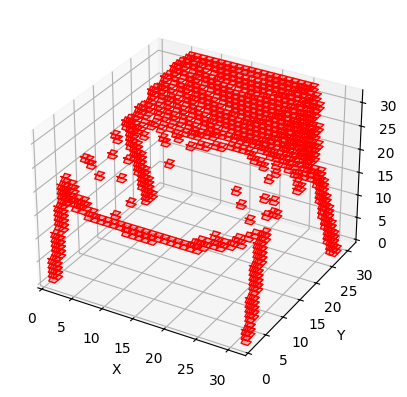

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d_tensor_boxes(tensor):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extracting indices where the value is 1
    for i in range(len(tensor)):
        for j in range(len(tensor[i])):
            for k in range(len(tensor[i][j])):
                if tensor[i][j][k] >= 0.5:
                    cube = [(i, j, k), (i+1, j, k), (i+1, j+1, k), (i, j+1, k),
                            (i, j, k+1), (i+1, j, k+1), (i+1, j+1, k+1), (i, j+1, k+1)]

                    ax.add_collection3d(Poly3DCollection([cube], color='r', alpha=0.25))
    ax.set_xlim([0, 32])
    ax.set_ylim([0, 32])
    ax.set_zlim([0, 32])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()
plot_3d_tensor_boxes(y_test[0])

# Red GAN

In [47]:
import tensorflow as tf
from keras import layers, models

generator = models.Sequential([
    layers.Input(shape=(128, 128, 1)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(256, kernel_size=4, strides=2, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.5),  # dropout
    layers.Dense(4 * 4 * 4 * 128, activation="relu"),
    layers.Reshape((4, 4, 4, 128)),
    layers.Conv3DTranspose(64, kernel_size=4, strides=2, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv3DTranspose(64, kernel_size=4, strides=2, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv3DTranspose(1, kernel_size=4, strides=2, padding="same", activation="sigmoid")
])

discriminator = models.Sequential([
    layers.Conv3D(64, kernel_size=4, strides=2, padding="same", input_shape=(32, 32, 32, 1)),
    layers.Conv3D(128, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.5), 
    layers.Dense(1, activation="sigmoid")
])

discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

discriminator.trainable = False

gan_input = layers.Input(shape=(128, 128, 1))
fake_voxels = generator(gan_input)
gan_output = discriminator(fake_voxels)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss="binary_crossentropy", optimizer="adam")


3/3 [==============================] - 2s 548ms/step


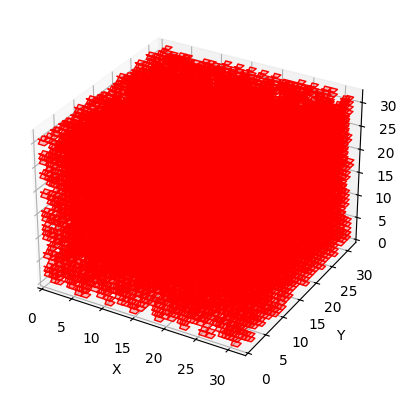

In [45]:
plot_3d_tensor_boxes(generator.predict(X_test)[0])

In [37]:
print(y_train[0])

[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [1]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [1]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [1]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [1]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [1]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [1]
   [1]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 ...


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]

# Entrenamiento

In [48]:
import numpy as np

X_train = np.reshape(X_train, (len(X_train), 128, 128, 1))
y_train = np.reshape(y_train, (len(y_train), 32, 32, 32, 1))

epochs = 5
batch_size = 16

# Training loop
for epoch in range(epochs):
    generated_voxels = generator.predict(X_train)

    generated_voxels_binary = (generated_voxels >= 0.5).astype('float32')

    x_combined = np.concatenate([y_train, generated_voxels])
    y_combined = np.concatenate([np.ones((len(y_train), 1)), np.zeros((len(y_train), 1))])
    discriminator.trainable = True
    d_loss, d_acc = discriminator.train_on_batch(x_combined, y_combined)
    discriminator.trainable = False

    random_input = np.random.normal(0, 1, size=(len(X_train), 128, 128, 1))
    y_fake = np.ones((len(X_train), 1))

    g_loss = gan.train_on_batch(random_input, y_fake)

    print(f"Epoch {epoch}/{epochs}, D Loss: {d_loss}, D Accuracy: {d_acc * 100}%, G Loss: {g_loss}")    


26/26 [==============================] - 19s 714ms/step
Epoch 0/5, D Loss: 0.8266825675964355, D Accuracy: 54.24242615699768%, G Loss: 5.845569133758545
26/26 [==============================] - 20s 754ms/step
Epoch 1/5, D Loss: 0.1193811222910881, D Accuracy: 98.66666793823242%, G Loss: 7.5337018966674805
26/26 [==============================] - 19s 721ms/step
Epoch 2/5, D Loss: 0.1372690349817276, D Accuracy: 98.42424392700195%, G Loss: 5.096463203430176
26/26 [==============================] - 19s 729ms/step
Epoch 3/5, D Loss: 0.8445269465446472, D Accuracy: 76.18181705474854%, G Loss: 15.002037048339844
26/26 [==============================] - 19s 715ms/step
Epoch 4/5, D Loss: 0.25140559673309326, D Accuracy: 98.54545593261719%, G Loss: 19.72571563720703


In [7]:
generated_images = generator.predict(X_test)
print(np.count_nonzero(generated_images[0] == 0))
print(np.count_nonzero(generated_images[0] == 1))

3/3 [==============================] - 1s 490ms/step
32154
518


## Primeros resultados de entrenamiento

3/3 [==============================] - 2s 490ms/step


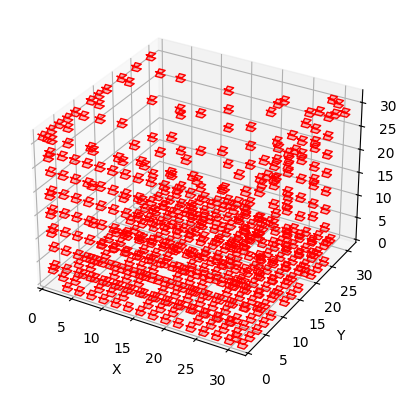

In [12]:
# 10 epochs
plot_3d_tensor_boxes(generator.predict(X_test)[0])

3/3 [==============================] - 2s 506ms/step
31216
1530


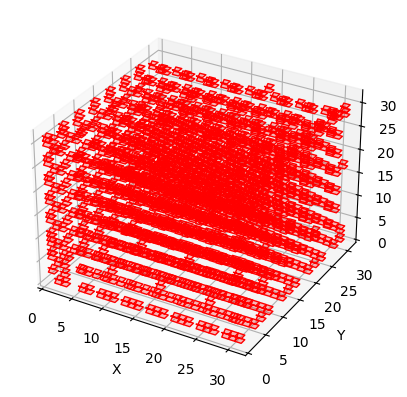

In [14]:
# 15 epochs
generated_images = generator.predict(X_test)
print(np.count_nonzero(generated_images[0] == 0))
print(np.count_nonzero(generated_images[0] == 1))
plot_3d_tensor_boxes(generated_images[0])

3/3 [==============================] - 1s 470ms/step
28156
4601


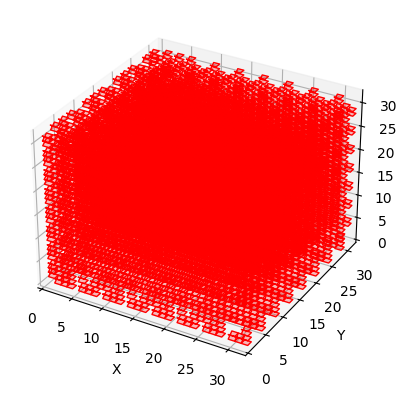

In [16]:
# 20 epochs
generated_images = generator.predict(X_test)
print(np.count_nonzero(generated_images[0] == 0))
print(np.count_nonzero(generated_images[0] == 1))
plot_3d_tensor_boxes(generated_images[0])

3/3 [==============================] - 1s 483ms/step
26471
6230


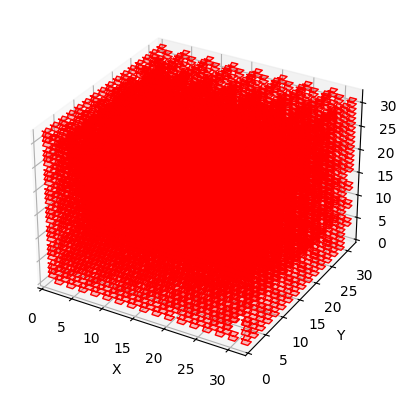

In [18]:
# 25 epochs
generated_images = generator.predict(X_test)
print(np.count_nonzero(generated_images[0] == 0))
print(np.count_nonzero(generated_images[0] == 1))
plot_3d_tensor_boxes(generated_images[0])

## Segundos resultados de entrenamiento

3/3 [==============================] - 2s 792ms/step
0
0


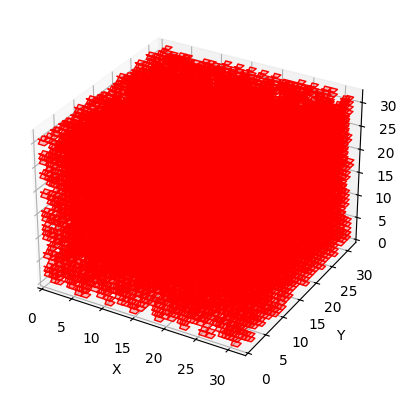

In [46]:
# 5 epochs
generated_images = generator.predict(X_test)
print(np.count_nonzero(generated_images[0] == 0))
print(np.count_nonzero(generated_images[0] == 1))
plot_3d_tensor_boxes(generated_images[0])

3/3 [==============================] - 1s 491ms/step
30934
1829


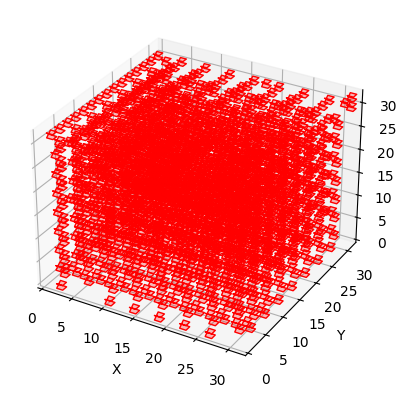

In [25]:
# 10 epochs
generated_images = generator.predict(X_test)
print(np.count_nonzero(generated_images[0] == 0))
print(np.count_nonzero(generated_images[0] == 1))
plot_3d_tensor_boxes(generated_images[0])

3/3 [==============================] - 2s 533ms/step
31221
1547


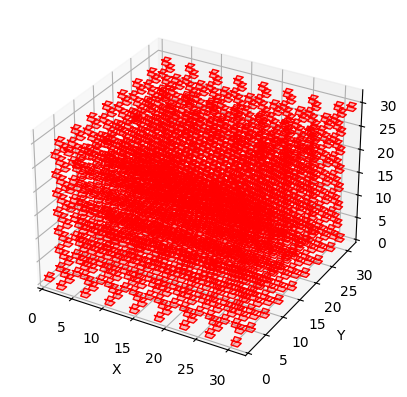

In [27]:
# 15 epochs
generated_images = generator.predict(X_test)
print(np.count_nonzero(generated_images[0] == 0))
print(np.count_nonzero(generated_images[0] == 1))
plot_3d_tensor_boxes(generated_images[0])

# Conclusión
El loss de la red GAN disminuye lentamente en las primeras 5 épocas pero luego se dispara.